In [1]:
import numpy as np
import scipy as sp
from scipy.cluster.vq import vq, kmeans2, whiten
import matplotlib.pyplot as plt

import scipy.sparse.linalg
import torch
import torch.nn as nn
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

In [2]:
from crf.gaussian_matrix import LatticeGaussian, LatticeFilter, RbfLaplacian#, LSHGaussian
from crf.utils import read_image, read_pfm, read_pgm
from crf.features import Vgg16features
from crf.crf import *
from crf.depth import *

In [3]:
%cd depth-estimation/Experiments/
img = read_image('101087.jpg')#[::2,::2]
#img = read_image('imL.png')

/home/marc/depth-estimation/Experiments


In [4]:
d=5
class ReferenceMatrix(nn.Module):
    def __init__(self):
        super().__init__()
        #self.projection = nn.Linear(64,d)#0.063,.052
        self.sigma_c = nn.Parameter(torch.tensor(.08).float())
        self.sigma_p = nn.Parameter(torch.tensor(.03).float())
    def forward(self,img,nn_features):
        #projected_features = self.projection(nn_features)/10
        scaled_rgb = torch.from_numpy(img).float()/self.sigma_c
        h,w,_ = img.shape
        ij = torch.from_numpy(np.mgrid[:h,:w].transpose((1,2,0))/np.sqrt(h**2+w**2)).float()
        scaled_ij = ij/self.sigma_p
        #print(ij.shape,scaled_rgb.shape, projected_features.shape)
        return torch.cat([scaled_ij,scaled_rgb],dim=-1).reshape(h*w,5)#,
    
referenceMatrix = ReferenceMatrix()
ref = referenceMatrix(img,None)
L = RbfLaplacian(ref)

In [5]:
L_op = sp.sparse.linalg.LinearOperator(L.shape,lambda v: (L@torch.from_numpy(v).float().unsqueeze(-1)).squeeze().data.numpy()) + 1e-4*identity_op(img.shape)

In [41]:
k=14

In [7]:
with torch.no_grad():
    w,v = sp.sparse.linalg.eigsh(L_op,maxiter=30,which='SM',k=k+1,tol=1e-4)

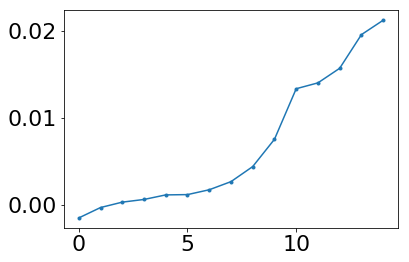

In [14]:
plt.plot(w,marker='.')

In [36]:
kk=500#k#10
whitened = whiten(v[:,w>0])
centroids, labels = kmeans2(whitened, kk)
oh_labels = np.stack([labels==i for i in range(kk)],axis=0)
coloring = oh_labels@img.reshape(-1,3)/(oh_labels.sum(-1)[:,None]+1e-4)
colored_labels = (oh_labels.T@coloring).reshape(img.shape)

/home/marc/anaconda3/lib/python3.6/site-packages/scipy/cluster/vq.py:525: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


Text(0.5, 1.0, 'Original Image')

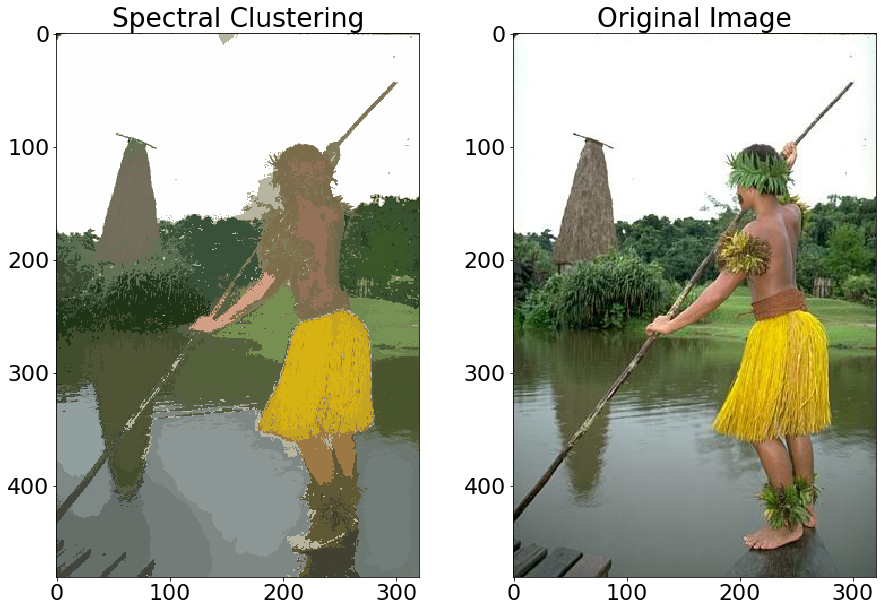

In [38]:
plt.rcParams.update({'font.size': 22})
f, axarr = plt.subplots(1,2,figsize=(15,10))
a0 = axarr[0].imshow(colored_labels)
a1 = axarr[1].imshow(img)
axarr[0].set_title("Spectral Clustering")
axarr[1].set_title("Original Image")

2 7


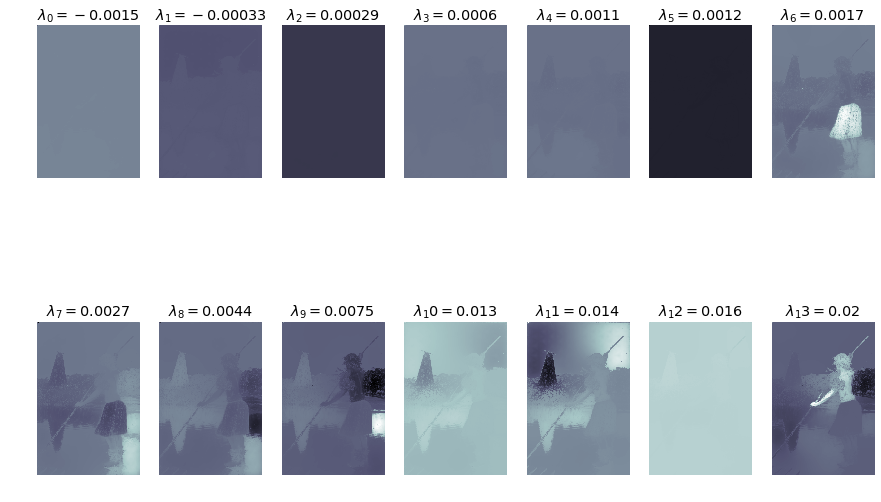

In [65]:
plt.rcParams.update({'font.size': 12})
rows = int((np.sqrt(k)*3)//4)
cols = int(k//rows)
print(rows,cols)
f, ax = plt.subplots(rows,cols,figsize=(15,10))
plt.axis('off')
for i in range(rows):
    for j in range(cols):
        # create subplot and append to ax
        m = i*cols+j
        ax[i,j].set_axis_off()
        ax[i,j].imshow(v[:,m].reshape(img.shape[:2]),cmap='bone')
        ax[i,j].set_title(rf"$\lambda_{m}={w[m]:{2}.{2}}$")
plt.show()

In [40]:
k

0